In [1]:
import os

c = os.getcwd()
print(c)

/home/rhosane/Data_science Project/Week 3 - ecommerce


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

for dirname, _, filenames in os.walk(c):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns; 
sns.set_theme()

In [3]:
df_raw = pd.read_csv("{adress}/out.csv".format(adress=c),parse_dates=['InvoiceDate'], encoding= 'unicode_escape').drop(columns='Unnamed: 8')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df = df_raw.copy()
print("Percentage of missing data %:")
df.isnull().sum()*100/len(df)

Percentage of missing data %:


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Costumers segmentation case

The dataset contains the following informations from an e-commerce retail platform located in United Kingdom:
- ID of a customer (CustomerID)
- ID of transactions (InvoiceNo). In theory, each transaction is related to a customer
- ID of products (StockCode). Each product is related to a transaction.
- Description of the product/operation (Description)
- Quantity of products bought (Quantity)
- Date of the transaction (InvoiceDate)
- Price of a product unit (UnitPrice)
- Country where the transaction was demanded (Country)

It is available at https://www.kaggle.com/datasets/vijayuv/onlineretail
In this case, the marketing team could ask me to identify costumers types.<br />
So that they could launch a directioned campaign for them.<br />

#### __Summarizing my aproach direction__:
In a first glance, the variables I think that are interesting for us to dive in are: <br />
A | In the __transaction's level__: 
- Revenue per transaction (it gives us an idea of the purchasing power)<br />
- Postage fee (investigate if it is important for the analysis)
__Dataframe code:__ __df_transaction__

B | In the __costumer's level__: 
I will use the RFM methodology to identify the best customers. Where RFM stands for recency, frequency and monetary.
These features are mentioned below:
- Mean revenue per customer (it gives us an idea of customer's purchasing power)
- Average time between transactions (it gives us an idea of the frequency the customer buys)
- Recency (how many days until now there wasn't purchase from a customer)<br />
__Dataframe code:__ __df_customer__


#### __Questions to be answered__:
- Who are the people eligible to join directioned campaigns?
- What are the main characteristics of these customers?
- What actions can the marketing team take to increase revenue?


Keywords: data manipulation, standardization, clusterization, K-Means

# 1 | Data preparation \& EDA 

## 1.1 | Cash received (revenue)<br />
Let's check out the revenue of the enterprise accordingly to the dataset:

In [7]:
df['revenue']=df['Quantity']*df['UnitPrice']

Because our objective is analyse purchases related to the revenue, we're going take into account only positive quantities and prices. 

In [8]:
df = df.loc[((df['Quantity']>0)&(df['UnitPrice']>0))]
print('Percentage of the data kept:{:.2f}%'.format((len(df)/len(df_raw)*100)))

Percentage of the data kept:97.82%


Dates can be important for us to identify some pattern in the shoppings:

In [9]:
df['month'] = df['InvoiceDate'].dt.month
df['year']=df['InvoiceDate'].dt.year
print("Percentage of the data available per year")
df['year'].value_counts()*100/len(df)

Percentage of the data available per year


2017    92.17512
2016     7.82488
Name: year, dtype: float64

#### 1.1.1 | Missing values

In [10]:
print('Percentage of rows % without customerID per year relating to the total amount lines:')
print(df['year'].loc[df['CustomerID'].isnull()].value_counts()/len(df)*100)

Percentage of rows % without customerID per year relating to the total amount lines:
2017    22.051711
2016     2.890565
Name: year, dtype: float64


It's a good practice to have the costumersID in a string format:

In [11]:
df['CustomerID']=df['CustomerID'].astype(object)

We aren't going to consider rows assigned to NaN customerID as valid ones, because we want to map costumer's behavior.

In [12]:
#Droping transactions without customer assigned
df.dropna(subset=['CustomerID'], axis=0, inplace=True)

#### 1.1.2 | UnitPrice variation

Unitprice variation can give us a clue if postage costs are included in the database control. Since they are generally variable.

In [13]:
unit_price_std =pd.DataFrame(df.groupby(by='StockCode', as_index=False)['UnitPrice'].std()).sort_values("UnitPrice", ascending=False)
unit_price_std.head(5)

,StockCode,UnitPrice
3662,M,585.474585
3661,DOT,540.829708
3664,POST,247.506606
1508,22656,66.039761
1507,22655,62.136568


There's a subtle increase in the variance of prices for StockCode named DOT, POST and M. <br />
Looking further into them:

In [14]:
for i in range(4):
    print('Unique Description values for {descript}'.format(descript=unit_price_std.iloc[i,0]))
    print(df['Description'].loc[df['StockCode']==unit_price_std.iloc[i,0]].unique())

Unique Description values for M
['Manual']
Unique Description values for DOT
['DOTCOM POSTAGE']
Unique Description values for POST
['POSTAGE']
Unique Description values for 22656
['VINTAGE BLUE KITCHEN CABINET']


In [15]:
labels_price_std= unit_price_std.iloc[1:3,0].unique().tolist()

DOT and POST stand for postage (livraison). It might be a good ideia signalize in our database the percentage of the transaction revenue destined to it. <br />

In [16]:
df['postage_revenue'] = np.where((df['StockCode'].isin(labels_price_std)), (df['revenue']), 0)
df['postage_revenue'].value_counts()

0.00       396769
36.00         200
18.00         184
54.00         133
72.00          63
            ...  
36.50           1
11.17           1
16.46           1
165.00          1
1599.26         1
Name: postage_revenue, Length: 83, dtype: int64

## 1.2 | Data manipulation

Accordingly to the internal team, the postages fees are mainly used for paying logistic services, so I'm not going to add them in the revenue metric.
Decomposing the original dataframe df into a transaction df: <br />

In [17]:
#Removing postage lines. Considering that they would be more assotiated to costs for the company
df_without_postage_lines=df.loc[~((df['StockCode']=='DOTCOM POSTAGE')|(df['StockCode']=='POSTAGE'))]

#New table with 2 columns: InvoiceNo and transaction revenue
df_transaction = df_without_postage_lines.groupby(by='InvoiceNo',as_index=False)['revenue'].agg('sum').rename(columns={"revenue":"revenue_per_transaction"})

In [18]:
#Creating feature for postage in a transaction:
df_transaction_quantity_products_postage = df.groupby(by='InvoiceNo',as_index=False)['postage_revenue'].agg('sum').rename(columns={"postage_revenue":"postage_revenue_per_transaction"})

#Merging the tables:
df_transaction= pd.merge(df_transaction, df_transaction_quantity_products_postage, on='InvoiceNo', how='left')
df_transaction= pd.merge(df_transaction, df[['Country','InvoiceNo','CustomerID','InvoiceDate','year','month']], on='InvoiceNo', how='left')
df_transaction.drop_duplicates(inplace=True)

#Creation of a feature that registers the percentage of postage relating to the revenue
df_transaction["percentage_of_postage_in_revenue"]= (df_transaction['postage_revenue_per_transaction']/(df_transaction['postage_revenue_per_transaction']+df_transaction['revenue_per_transaction']))

#So that we can track when the transaction was made in the orgin country or not
df_transaction['national'] = np.where((df_transaction['Country'].isin(['United Kingdom'])), 1, 0)

### 1.2.1 | EDA transactions 

We aim to gather some insights through this data using the issues/contexts below:
- Available dates alow us to visualize the company's transactions revenue performance over time.
- In average, costumers in England pay less postage fees compared to the average of foreign countries?

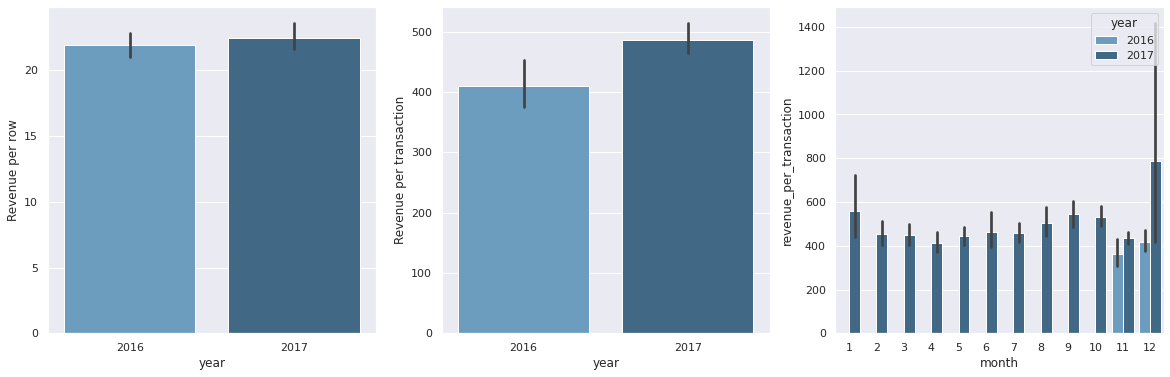

In [19]:
f, axes = plt.subplots(1,3,figsize=(20,6))
sns.barplot(x="year", y="revenue", data=df, palette="Blues_d",ax=axes[0]).set(ylabel='Revenue per row')
sns.barplot(x="year", y="revenue_per_transaction", data=df_transaction, palette="Blues_d",ax=axes[1]).set(ylabel='Revenue per transaction')
sns.barplot(x="month", y="revenue_per_transaction", hue="year", data=df_transaction, palette="Blues_d", ax= axes[2])
plt.show()

We can see the revenue central tendency in the retangle per year and its uncertantity in the lines. <br />
In 2017, there was a increase in the median revenue per row and in the <br />
revenue per transaction compared to 2016. Indeed we can observe this in the third figure <br />
with the central tendency per month.

In [20]:
postage_comparator = df_transaction.groupby(by='national', as_index=False)[['revenue_per_transaction','postage_revenue_per_transaction']].agg('sum')
postage_comparator['postage_percentage_per_country'] = (100*postage_comparator['postage_revenue_per_transaction']/(postage_comparator['revenue_per_transaction']+postage_comparator['postage_revenue_per_transaction']))
postage_comparator['percentage_of_transactions_quantity'] = (100*df_transaction['national'].value_counts()/len(df_transaction))
postage_comparator[['national','postage_percentage_per_country','percentage_of_transactions_quantity']].sort_values(by='postage_percentage_per_country', ascending=False)

,national,postage_percentage_per_country,percentage_of_transactions_quantity
0,0,4.127897,10.176991
1,1,0.282305,89.823009


Costumers based in UK pay 0.3% of postage fee on revenue against 4.2% payed by costumers based in foreign countries in average. <br />
Besides, 89% of the transactions were destined to UK.

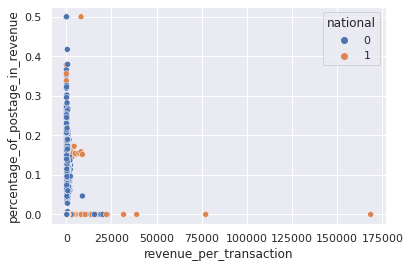

In [21]:
sns.scatterplot(x="revenue_per_transaction", y="percentage_of_postage_in_revenue",hue='national', data=df_transaction)
plt.show()

With the scaterplots, we note that:<br />
Percentage of postage in revenue ranges from 0% to 50%. <br />            

### 1.2.2 | Df CUSTOMERS

I'm going to agglomerate features derived from df_transactions to see its effets on customer metrics.

In [22]:
#Creating features and associating them to tables
df_customer_transaction_quantity = pd.DataFrame(df_transaction.value_counts('CustomerID')).reset_index().rename({0:'transactions_quantity'}, axis=1)

#Features related to time
df_customer_time=df_transaction.groupby(by='CustomerID')['InvoiceDate'].agg(['min','max'])
df_customer_time['time_interval']=(df_customer_time['max']-df_customer_time['min']).dt.days
df_customer_time['recency']=(df_customer_time['max'].max()-df_customer_time['max']).dt.days

#Merging the tables/features
df_customer = pd.merge(df_customer_transaction_quantity,df_customer_time, on='CustomerID', how='left')

df_customer['avg_time_between_transactions']=(df_customer['time_interval']/df_customer['transactions_quantity'])

df_customer_revenue=df_transaction.groupby(by="CustomerID")["revenue_per_transaction"].agg('mean').reset_index().rename({'revenue_per_transaction':'mean_revenue_per_customer'}, axis=1)
df_customer=pd.merge(df_customer,df_customer_revenue,on='CustomerID', how='left')

df_customer.fillna(0,inplace=True)

In [23]:
df_customer.head()

,CustomerID,transactions_quantity,min,max,time_interval,recency,avg_time_between_transactions,mean_revenue_per_customer
0,12748.0,209,2016-11-29,2017-12-07,373,0,1.784689,161.338421
1,14911.0,201,2016-11-29,2017-12-06,372,1,1.850746,715.547562
2,17841.0,124,2016-11-29,2017-12-06,372,1,3.000000,330.577177
3,13089.0,97,2016-12-03,2017-12-05,367,2,3.783505,606.451856
4,14606.0,93,2016-11-29,2017-12-06,372,1,4.000000,130.716667


In [24]:
print("Quantity of customers to be analysed:{customers}".format(customers=len(df_customer)))

Quantity of customers to be analysed:4338


Relevant features to identify the high-valued customers and so to be used in the clusterization:

In [25]:
df_customer_for_cluster_original=df_customer[['mean_revenue_per_customer','avg_time_between_transactions','recency','CustomerID']]
df_customer_for_cluster_original.set_index("CustomerID", inplace=True)

Since I'm going to use kmeans which is very sensitive to outliers. I'm going to remove outliers using the definition of interquartile range through the function below.

In [26]:
inf = []
sup = []
j=0
df_customer_for_cluster = df_customer_for_cluster_original.copy()
for i in df_customer_for_cluster_original.columns:
    Q1 = df_customer_for_cluster_original[f'{i}'].quantile(0.25)
    Q3 = df_customer_for_cluster_original[f'{i}'].quantile(0.75)
    IQR = Q3 - Q1
    inf.append(Q1 - 1.5*IQR)
    sup.append(Q3 + 1.5*IQR)
    df_customer_for_cluster = df_customer_for_cluster[((df_customer_for_cluster[f'{i}'] >= inf[j]) & (df_customer_for_cluster[f'{i}'] <= sup[j]))]

    j=j+1

print("Quantity of customers to be analysed:{customers}".format(customers=len(df_customer_for_cluster)))
print(f"{len(df_customer)-len(df_customer_for_cluster)} customers were removed. Consisting in {100*(len(df_customer)-len(df_customer_for_cluster))/len(df_customer):.2f}% of the data")

Quantity of customers to be analysed:3808
530 customers were removed. Consisting in 12.22% of the data


Scaling the data kept, then the original data with outliers:

In [27]:
columns = df_customer_for_cluster.columns.tolist()
features = df_customer_for_cluster[columns]

#fitting and saving the model
scaler = StandardScaler().fit(features.values) 
df_scaled = scaler.transform(features.values)

df_customer_for_cluster_scaled = pd.DataFrame(df_scaled, columns = columns, index=df_customer_for_cluster.index)
#################################################
#   Scaling the original dataframe with outliers
columns = df_customer_for_cluster_original.columns.tolist()
original_features = df_customer_for_cluster_original[columns]

df_original_scaled = scaler.transform(original_features.values)
df_customer_for_cluster_original_scaled = pd.DataFrame(df_original_scaled, columns = columns, index=df_customer_for_cluster_original.index)

In [30]:
#Veryfing the scaled data
df_customer_for_cluster_scaled.head(5)

,mean_revenue_per_customer,avg_time_between_transactions,recency
CustomerID,,,
12748.0,-0.857388,-0.900500,-0.947733
14911.0,2.510445,-0.898309,-0.936388
17841.0,0.171047,-0.860190,-0.936388
13089.0,1.847490,-0.834202,-0.925042
14606.0,-1.043471,-0.827021,-0.936388


## 2 | KMeans 
Here I ploted both important metrics to evaluate the costumer segmentation versus the number of clusters.<br />
The **inertia** which mesures the "sum of squared distances of samples to their closest cluster center". <br />
And the **silhouette score** that ranges from -1 to +1. The closer to +1, it relates to a model with "better defined clusters". <br />
0 means overlapping clusters and closer to -1 means worse models.

In [31]:
def kmeans(df):
    J =[]
    sil_score=[]
    clusters= range(2,11)
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=0).fit(df)
        sil_score.append(silhouette_score(df, model.labels_, metric='euclidean'))
        J.append(model.inertia_)

    s1=pd.Series(clusters)
    s2=pd.Series(J)
    s3=pd.Series(sil_score)
    Jgraphic=pd.concat([s1, s2], axis=1)
    Silgraphic=pd.concat([s1, s3], axis=1)

    f, axes = plt.subplots(1,2,figsize=(18,6))
    sns.lineplot(x=0,y=1,data=Jgraphic, ax= axes[0])
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Cost')
    axes[0].set_title('KMeans')

    sns.lineplot(x=0,y=1,data=Silgraphic, ax= axes[1])
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Silhouette score')
    return plt.show()   

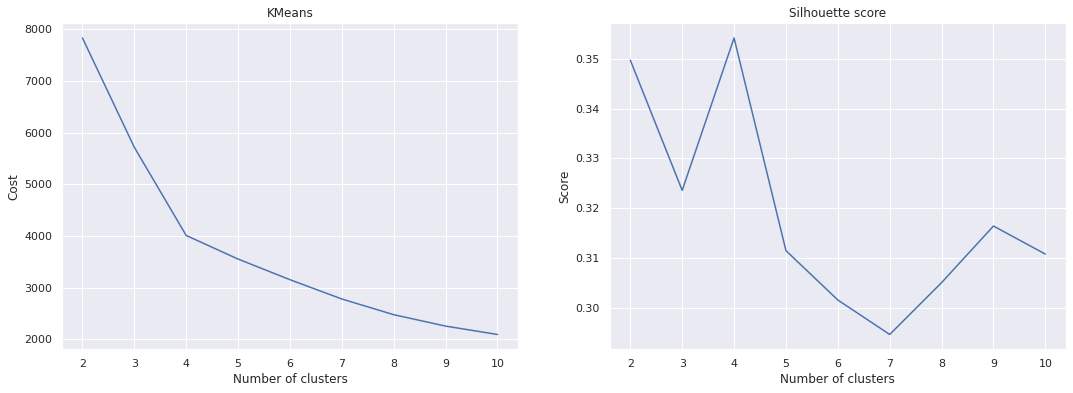

In [32]:
kmeans(df_customer_for_cluster_scaled)

The number of clusters to be chosen is the one that combines a lower inertia, accordingly to the elbow method and its suitability to the problem, and a bigger silhouette score.
We choose nclusters=4:

In [33]:
model = KMeans(n_clusters=4, random_state=0).fit(df_customer_for_cluster_scaled)
df_customer_for_cluster_scaled['kmeans_cluster'] = model.labels_


In [34]:
def segmentation_in_3d(df, model_name, angle):
    list = df[f'{model_name}'].unique().tolist()
    fig = plt.figure(figsize=(21,10))
    ax = fig.add_subplot(111, projection='3d')
    color =['purple','green','red','orange','black']
    for i in range(len(list)):
            ax.scatter(df[f'{df.columns[0]}'][df[f'{model_name}'] == list[i]], df[f'{df.columns[1]}'][df[f'{model_name}'] == list[i]], df[f'{df.columns[2]}'][df[f'{model_name}'] == list[i]], c=f'{color[i]}', s=60)
    ax.set_xlabel(f'{df.columns[0]}')
    ax.set_ylabel(f'{df.columns[1]}')
    ax.set_zlabel(f'{df.columns[2]}')
    ax.set_title('Scaled axes')
    
    #to limit the x axis uncomment below
    #plt.xlim([3, -2])


    ax.view_init(30, angle)
    return plt.show()

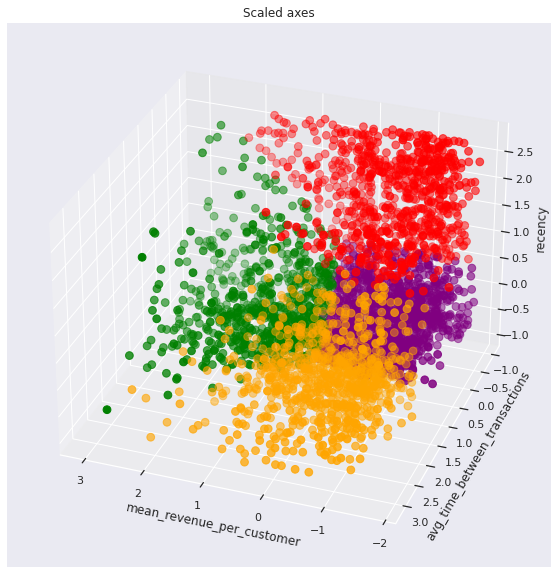

In [35]:
segmentation_in_3d(df_customer_for_cluster_scaled,'kmeans_cluster',110)

Looking to the 3d-graphic above we see 4 clusters that can well describe caracteristics of a costumer. Although the silhouette score is not high (about 0.35). <br />

In the pairplot below, in the diagonals we can see the distribution of each segmentation. At the position:
- [line 1, column 1], cluster 2 has the range of observations with the highest average revenue. <br />
- [line 2, column 2], cluster 0 has the range of observations with the highest average time between transactions. __Not desirable__. Clients that buy more often are better. <br />
- [line 3, column 3], cluster 1 has the range of observations with the highest recency. __Not desirable either__ because recency indicates how many days have passed since the last client shop. So the longer, the worst.<br />

Finaly, cluster 3 has recency and average time ranges favorables, but its revenue per customer range isn't as high as we expected.<br />
Through the rest of the pairplot graphics, we can see points from one cluster in the middle of another cluster area. This indicates a not-great separability of the data, explaining also the low silhouette score. 

<Figure size 1440x2160 with 0 Axes>

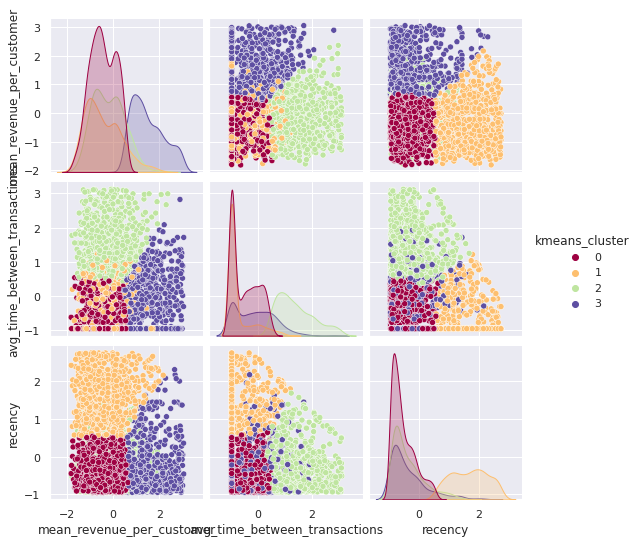

In [36]:
plt.figure(figsize=(20,30))
sns.pairplot(df_customer_for_cluster_scaled, hue='kmeans_cluster',palette="Spectral")
plt.xticks(rotation=45)
plt.show()

In [37]:
df_costumer_kmeans_final = pd.merge(df_customer_for_cluster,df_customer_for_cluster_scaled, on='CustomerID', how='left',suffixes=('', '_scaled'))
df_costumer_kmeans_final.groupby('kmeans_cluster').agg(['count'])

,mean_revenue_per_customer,avg_time_between_transactions,recency,mean_revenue_per_customer_scaled,avg_time_between_transactions_scaled,recency_scaled
,count,count,count,count,count,count
kmeans_cluster,,,,,,
0,1355,1355,1355,1355,1355,1355
1,779,779,779,779,779,779
2,927,927,927,927,927,927
3,747,747,747,747,747,747


In [38]:
teste=df_costumer_kmeans_final.groupby('kmeans_cluster').agg(['count'])
teste.sum()

mean_revenue_per_customer             count    3808
avg_time_between_transactions         count    3808
recency                               count    3808
mean_revenue_per_customer_scaled      count    3808
avg_time_between_transactions_scaled  count    3808
recency_scaled                        count    3808
dtype: int64

### 2.1 | What about the outliers?

Just for curiosity, I plotted all the data clustered including the outliers. But indeed, they need to be analysed carefully. Taking their table and studying from which space cluster they would belong to.

In [39]:
#assigning k-Means model for the data with outliers
df_customer_for_cluster_original_scaled['kmeans_cluster'] = model.predict(df_customer_for_cluster_original_scaled)

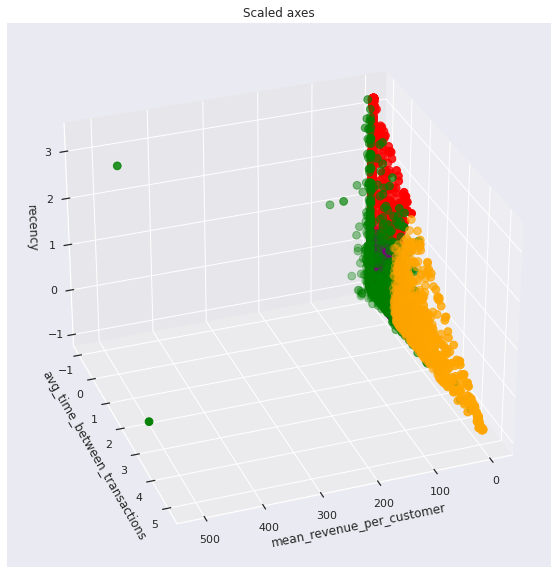

In [40]:
segmentation_in_3d(df_customer_for_cluster_original_scaled,'kmeans_cluster',70)

In [28]:
print("Superior limit for not be considered oulier",sup)
print("Inferior limit for not be considered oulier",inf)

Superior limit for not be considered oulier [807.346875, 123.21428571428572, 328.875]
Inferior limit for not be considered oulier [-198.60812499999997, -73.92857142857143, -170.125]


Here are an idea to approach the outliers: <br /> Since we only have positive outliers, as indicates the inferior limits above.
We can estimate the quantity of clusters considering 2 options: being an outlier or not. So it gives us 2³= 8 clusters, but one of them has already been analysed, which is the case none of the features has outliers. For the 7 options, we can breakdown further attributing 2 options for non-outlier feature case: when the value of the feature is lower or higher. The schema below presents this idea. 
However it is not the focus work with them now, because they are extreme cases that I don't want to consider this assumption now.

1 - extrem high value <br />
0 - normal value (lower or higher): l or h <br />

mean_revenue_per_customer  |	avg_time_between_transactions | recency <br />
1 0 0   -> 4 cases<br />
1 0 1   -> 2 cases<br />
1 1 0   -> 2 cases <br />
1 1 1   -> 1 case <br />
0 0 0   -> already analysed in the k-Means clusterization
0 1 0   -> 4 cases<br />
0 0 1   -> 4 cases <br />
0 1 1   -> 2 cases <br />

In conclusion:
- Costumers that belongs to the 2nd cluster are model clients.
- Main characteristics of these customers: higher mean revenue per costumer, reasonable lower average time between transactions and recency.
- What actions can the marketing team take to increase revenue?
It can build special interest clubs, so the clients can create communities and keep exclusivity.

Further detailed comments can be found on my medium page :)